In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
train = '/mnt/NewVolume/DUMP/Notebook/xray_analytics_cnn/data/BoneFractureDataset/training'
test = '/mnt/NewVolume/DUMP/Notebook/xray_analytics_cnn/data/BoneFractureDataset/testing'

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Preprocessing

In [4]:
def scale_images(x, y):
    return x / 255, y

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="categorical", validation_split=0.2, subset="training",seed=42)
train_data = train_data.map(scale_images)
train_size = int(len(train_data))
train_data_final = train_data.take(train_size)
print(train_size)

Found 8863 files belonging to 2 classes.
Using 7091 files for training.
222


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="categorical", validation_split=0.2, subset="validation", seed=42)
val_data = val_data.map(scale_images)
val_data_final = val_data.take(len(val_data))
print(len(val_data))

Found 8863 files belonging to 2 classes.
Using 1772 files for validation.
56


In [7]:
#VGG16

In [10]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')  
])

In [11]:
optimizer = RMSprop(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_data_final, epochs=10, validation_data=val_data_final, verbose=1, callbacks=[early_stopping])

Epoch 1/10
222/222 [==============================] - 13s 49ms/step - loss: 0.6985 - accuracy: 0.5812 - val_loss: 0.6739 - val_accuracy: 0.6016
Epoch 2/10
222/222 [==============================] - 11s 48ms/step - loss: 0.5809 - accuracy: 0.6731 - val_loss: 0.5841 - val_accuracy: 0.6569
Epoch 3/10
222/222 [==============================] - 11s 48ms/step - loss: 0.4928 - accuracy: 0.7563 - val_loss: 0.3767 - val_accuracy: 0.8555
Epoch 4/10
222/222 [==============================] - 11s 48ms/step - loss: 0.3836 - accuracy: 0.8246 - val_loss: 0.2911 - val_accuracy: 0.8984
Epoch 5/10
222/222 [==============================] - 11s 48ms/step - loss: 0.2941 - accuracy: 0.8742 - val_loss: 0.2839 - val_accuracy: 0.8787
Epoch 6/10
222/222 [==============================] - 11s 48ms/step - loss: 0.2218 - accuracy: 0.9112 - val_loss: 0.2045 - val_accuracy: 0.9176
Epoch 7/10
222/222 [==============================] - 11s 48ms/step - loss: 0.1610 - accuracy: 0.9363 - val_loss: 0.1161 - val_accuracy:

In [12]:
model.save('vgg16_cnn_opt.h5')

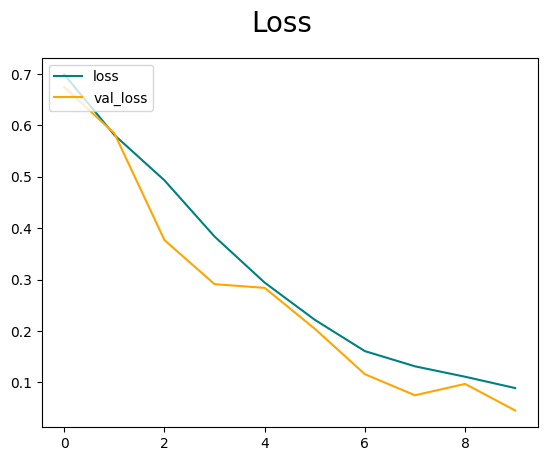

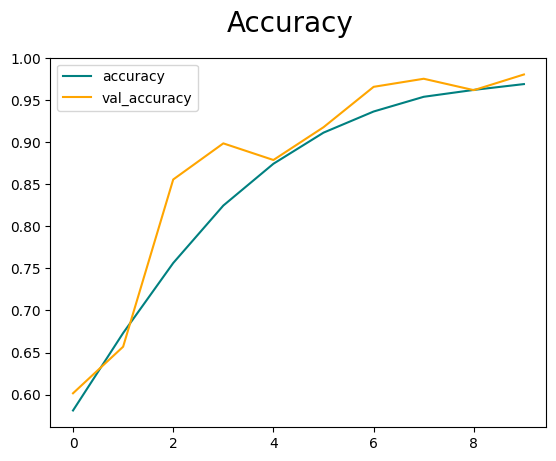

In [13]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()